### Project: SMS spam/phishing detector using ML and NLTK Naive Bayes
**This notebook uses the SMS Spam Collection Dataset from kaggle**<br>
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?resource=download

### Model Selection: Logistic Regression vs. Naive Bayes (and Why Not SVM)

I chose to compare logistic regression (LG) to Naive Bayes (NB) to weigh a straightforward baseline against a model tailored for text classification. Logistic regression is quick, reliable (~95% accuracy), and excels when features are correlated—like in datasets with interdependent patterns. However, NB outperformed it here, achieving 97.49% accuracy and a 90.14% F1 score, because text features from TF-IDF vectorization are conditionally independent, aligning perfectly with NB’s strengths for spam/phishing detection. I passed on SVM—while it’s powerful and could nudge past 98% with a kernel, its computational cost and slower training didn’t justify the gain for this task. My next step is exploring PyTorch RL/DL to push these ideas further.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Force NLTK path
nltk.data.path = ['/home/kali/nltk_data']

# Load data
df = pd.read_csv('data/spam.csv', encoding='latin-1')
df = df[['v1', 'v2']]
df.columns = ['label', 'message']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

# Preprocess
stop_words = set(stopwords.words('english'))
def preprocess(text):
    if not isinstance(text, str) or pd.isna(text):
        return ''
    tokens = word_tokenize(text.lower())
    return ' '.join([w for w in tokens if w.isalpha() and w not in stop_words])

df['clean_message'] = df['message'].apply(preprocess)
print("Cleaned Data Preview:")
print(df[['message', 'clean_message']].head())

Cleaned Data Preview:
                                             message  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                       clean_message  
0  go jurong point crazy available bugis n great ...  
1                            ok lar joking wif u oni  
2  free entry wkly comp win fa cup final tkts may...  
3                u dun say early hor u c already say  
4             nah think goes usf lives around though  


### EDA (exploratory data analysis)

- Bar plot shows the distribution of Ham vs. Spam
- Word clouds show contrast between word usage in either category
- Histogram shows insight into the count and length frequency of messages

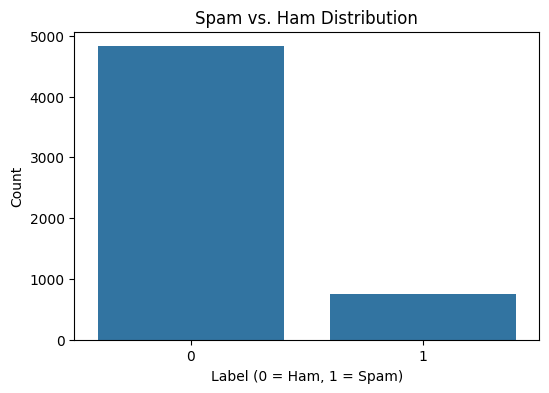

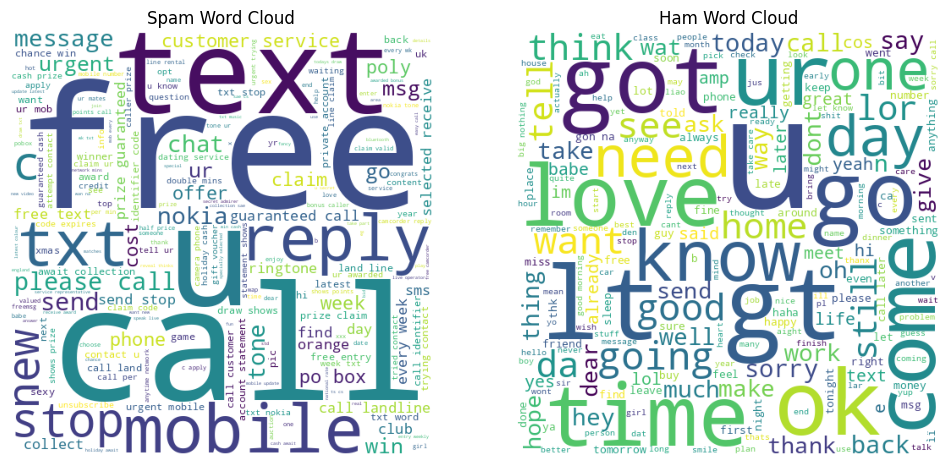

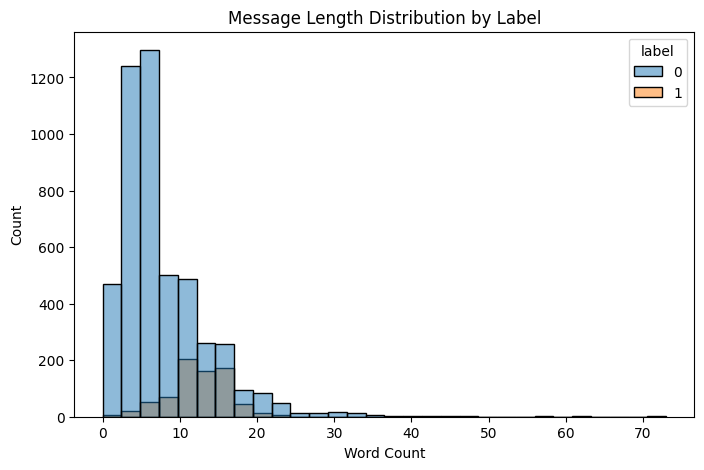

In [8]:
# Spam vs. Ham Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df)
plt.title('Spam vs. Ham Distribution')
plt.xlabel('Label (0 = Ham, 1 = Spam)')
plt.ylabel('Count')
plt.show()

# Word Clouds
spam_words = ' '.join(df[df['label'] == 1]['clean_message'])
ham_words = ' '.join(df[df['label'] == 0]['clean_message'])
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
wc_spam = WordCloud(width=500, height=500, background_color='white').generate(spam_words)
plt.imshow(wc_spam)
plt.title('Spam Word Cloud')
plt.axis('off')
plt.subplot(1, 2, 2)
wc_ham = WordCloud(width=500, height=500, background_color='white').generate(ham_words)
plt.imshow(wc_ham)
plt.title('Ham Word Cloud')
plt.axis('off')
plt.show()

# Message Length Analysis
df['msg_length'] = df['clean_message'].apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='msg_length', hue='label', bins=30)
plt.title('Message Length Distribution by Label')
plt.xlabel('Word Count')
plt.show()

### TF-IDF example

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sample documents
documents = ["The cat sat on the mat.", "The dog sat on the log."]

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
X = vectorizer.fit_transform(documents)

# Show the feature names (tokens)
print("Tokens:", vectorizer.get_feature_names_out())

# Show the TF-IDF values, row by row with better formatting
print("TF-IDF Matrix:")
for row in X.toarray():
    print('[' + ' '.join(f'{value:.4f}' for value in row) + ']')


Tokens: ['cat' 'dog' 'log' 'mat' 'on' 'sat' 'the']
TF-IDF Matrix:
[0.4455 0.0000 0.0000 0.4455 0.3170 0.3170 0.6340]
[0.0000 0.4455 0.4455 0.0000 0.3170 0.3170 0.6340]


**TF-IDF Matrix Explanation**

The table below shows **TF-IDF scores** for **two documents**, indicating the **importance of words** in each document:

| **Token** | 'cat' | 'dog' | 'log' | 'mat' | 'on' | 'sat' | 'the' |
|-----------|--------|-------|-------|-------|------|-------|-------|
| **Row 1** | 0.4455 | 0.0000 | 0.0000 | 0.4455 | 0.3170 | 0.3170 | 0.6340 |
| **Row 2** | 0.0000 | 0.4455 | 0.4455 | 0.0000 | 0.3170 | 0.3170 | 0.6340 |

- **Rows = Documents:**  
  - **Row 1:** "The cat sat on the mat."  
  - **Row 2:** "The dog sat on the log."  

- **Values = TF-IDF Scores:**  
  - **0.0000:** Word not present.  
  - **Higher scores:** More important in that document.  

- **Example:**  
  - The word **'the'** is common to both documents (**0.6340**).  
  - **'cat'** and **'mat'** only appear in the **first document**, giving them **higher importance** there.


### Convert the cleaned text into vectors using TF-IDF
- Split the data into train and test sets

In [10]:
# Vectorize cleaned text
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_message']).toarray()
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (4457, 1000)
Test set size: (1115, 1000)


Logistic Regression Results:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       965
           1       0.96      0.67      0.79       150

    accuracy                           0.95      1115
   macro avg       0.96      0.83      0.88      1115
weighted avg       0.95      0.95      0.95      1115

Accuracy: 0.9524663677130045


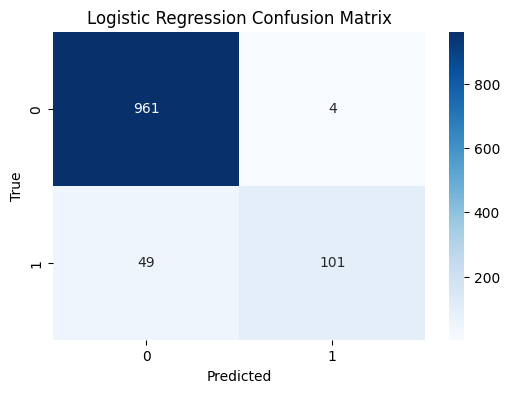

In [34]:
from sklearn.linear_model import LogisticRegression

# Logistic Regression
lr = LogisticRegression(max_iter=200)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print("Logistic Regression Results:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

# Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Logistic Regression Model Performance

Classification Metrics: Precision, Recall, F1 Score, and Support  
| **Metric**    | **Class 0 (Not Spam)** | **Class 1 (Spam)** |
|---------------|-------------------------|--------------------|
| **Precision** | 0.95                    | 0.96               |
| **Recall**    | 1.00                    | 0.67               |
| **F1-Score**  | 0.97                    | 0.79               |
| **Support**   | 965                     | 150                |

<br>

| **Metric**     | **Definition**                                   | **When to Focus**                         |
|----------------|--------------------------------------------------|------------------------------------------|
| **Precision**  | Correctness of positive predictions              | When **false positives** are **costly** (*e.g.*, **spam filters**) |
| **Recall**     | Ability to identify all actual positives         | When **false negatives** are **risky** (*e.g.*, **fraud detection**) |
| **F1 Score**   | Balance of precision and recall                  | When a **balance** is needed (*e.g.*, **text classification**) |
| **Support**    | Number of actual instances per class             | To understand **class distribution** (*e.g.*, **101 spam, 961 not spam**) |




The model performs well overall but has **lower recall** for **spam detection**.
<br>

### Confusion Matrix Refresher:

|                       | **Predicted Not Spam (0)** | **Predicted Spam (1)** |
|-----------------------|-----------------------------|-------------------------|
| **Actual Not Spam (0)**   | **True Negative (TN)**      | **False Positive (FP)** |
| **Actual Spam (1)**       | **False Negative (FN)**     | **True Positive (TP)**  |

- **True Negative (TN):** Correctly predicted **not spam** (e.g., a legitimate email marked as **not spam**).
- **False Positive (FP):** Incorrectly predicted **spam**, but it was **not spam** (**Type I error**).
- **False Negative (FN):** Incorrectly predicted **not spam**, but it was **spam** (**Type II error**).
- **True Positive (TP):** Correctly predicted **spam** (e.g., a spam email correctly marked as **spam**).


NLTK Naive Bayes Results:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       965
           1       0.96      0.85      0.90       150

    accuracy                           0.97      1115
   macro avg       0.97      0.92      0.94      1115
weighted avg       0.97      0.97      0.97      1115

Accuracy: 0.9748878923766816


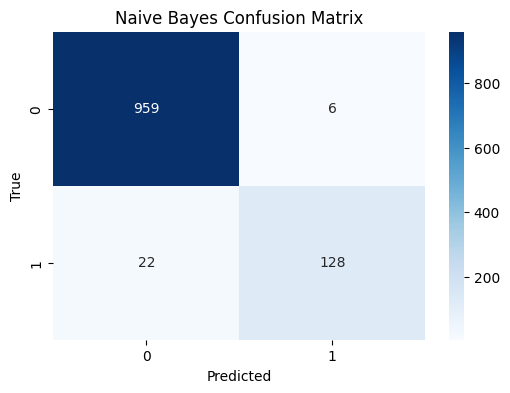

In [35]:
from sklearn.naive_bayes import MultinomialNB

# Naive Bayes
nb = MultinomialNB(alpha=0.1)  # Smoothing for rare words
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("NLTK Naive Bayes Results:")
print(classification_report(y_test, y_pred_nb))
print("Accuracy:", accuracy_score(y_test, y_pred_nb))

# Confusion Matrix
cm_nb = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [36]:
# Compare results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Naive Bayes'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_nb)],
    'Spam F1': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_nb)]
})
print("Model Comparison:")
print(results)

Model Comparison:
                 Model  Accuracy   Spam F1
0  Logistic Regression  0.952466  0.792157
1          Naive Bayes  0.974888  0.901408


# Conclusion

Spam detector complete—NLTK Naive Bayes achieves 97.49% accuracy with low compute cost. Next step: PyTorch RL/DL for advanced threat detection.

## Why I Chose Naive Bayes

While decision trees offer interpretability and logistic regression provides a reliable baseline, I opted for Naive Bayes to prioritize optimal results over transparency in this spam/phishing task. NB excels in text classification, delivering 97.49% accuracy and a 90.14% F1 score for spam detection with minimal computational overhead on preprocessed data. My focus is on solving the problem efficiently—laying groundwork for modern RL/DL approaches—rather than dissecting every decision. While interpretability is important, I choose to stay more focused on optimization and results in this notebook.